## AGENT DQN S'ENTRAÎNANT SUR TOUTES LES BOURSES AVEC L'AIDE D'UN MODÈLE DE PRÉDICTION UNIQUE (LSTM)

### INSTALLATION ET IMPORTATIONS

In [1]:
!pip install pandas numpy scikit-learn tensorflow gymnasium stable-baselines3 -q

### Import nécessaire

In [2]:
import pandas as pd
import numpy as np
import glob
import random
from pathlib import Path
# from google.colab import drive

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


### Chargement et Sélection des Données

In [3]:

print("\n--- PARTIE 1 : Chargement des données de toutes les bourses ---")

folder_path = 'Global Stock Market (2008-2023)/*.csv'
all_files = glob.glob(folder_path)
df_list = [pd.read_csv(filename) for filename in all_files]
df_full = pd.concat(df_list, ignore_index=True)

# --- Filtrer, nettoyer et stocker les données par ticker ---
data_by_ticker = {}
tickers_to_use = df_full['Ticker'].unique()

for ticker in tickers_to_use:
    df_ticker = df_full[df_full['Ticker'] == ticker].copy()
    if len(df_ticker) < 200:
        continue
    df_ticker['Date'] = pd.to_datetime(df_ticker['Date'])
    df_ticker.sort_values('Date', inplace=True)
    df_ticker.set_index('Date', inplace=True)
    data_by_ticker[ticker] = df_ticker[['Open', 'High', 'Low', 'Close', 'Volume']]

print(f"Données chargées pour {len(data_by_ticker)} tickers.")


--- PARTIE 1 : Chargement des données de toutes les bourses ---
Données chargées pour 12 tickers.
Données chargées pour 12 tickers.


### ENTRAÎNEMENT DU MODÈLE LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("\n--- PARTIE 2 : Entraînement d'un modèle LSTM généraliste sur plusieurs tickers ---")

# --- 1. Préparation des séquences pour tous les tickers ---

# Stocker de toutes les séquences (X) et leurs cibles (y)
all_X = []
all_y = []

sequence_length = 60

# Boucle sur chaque ticker dans notre dictionnaire de données
for ticker, df_ticker in data_by_ticker.items():
    print(f"Préparation des données pour le ticker : {ticker}...")
    
    close_prices = df_ticker['Close'].values.reshape(-1, 1)
    
    # IMPORTANT : Utilisation d'un nouveau scaler pour chaque ticker
    # afin que la normalisation soit propre à son échelle de prix.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(close_prices)
    
    # Créations de séquences pour le ticker spécifique
    X_ticker, y_ticker = [], []
    if len(scaled_prices) > sequence_length:
        for i in range(len(scaled_prices) - sequence_length):
            X_ticker.append(scaled_prices[i:i + sequence_length])
            y_ticker.append(scaled_prices[i + sequence_length])
        
        # Ajout des séquences du ticker aux listes globales
        all_X.extend(X_ticker)
        all_y.extend(y_ticker)

# --- 2. Combinaison, mélange et division des données ---

# Conversion en tableaux NumPy pour l'entraînement
X_combined = np.array(all_X)
y_combined = np.array(all_y)

# MÉLANGE (SHUFFLE) : Étape cruciale !
# On mélange les séquences pour que le modèle ne s'entraîne pas
# sur toutes les données d'Apple, puis toutes celles de Google, etc.
# Cela l'aide à généraliser.
X_shuffled, y_shuffled = shuffle(X_combined, y_combined, random_state=42)

# Division en ensembles d'entraînement et de validation
train_size = int(len(X_shuffled) * 0.9)
X_train, X_val = X_shuffled[:train_size], X_shuffled[train_size:]
y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:]

print(f"\nTotal de séquences d'entraînement créées : {len(X_train)}")
print(f"Total de séquences de validation créées : {len(X_val)}")

# --- 3. Construction et entraînement du LSTM ---
# Le code du modèle reste identique, il s'adapte automatiquement à la nouvelle donnée.
print("\nConstruction et entraînement du modèle LSTM...")
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, verbose=1) # Augmentation du batch_size
model_lstm.save('lstm_market_predictor.h5')
print("Modèle LSTM généraliste entraîné et sauvegardé.")


--- PARTIE 2 : Entraînement d'un modèle LSTM généraliste sur plusieurs tickers ---
Préparation des données pour le ticker : ^NYA...
Préparation des données pour le ticker : ^IXIC...
Préparation des données pour le ticker : ^FTSE...
Préparation des données pour le ticker : ^NSEI...
Préparation des données pour le ticker : ^BSESN...
Préparation des données pour le ticker : ^N225...
Préparation des données pour le ticker : 000001.SS...
Préparation des données pour le ticker : ^N100...
Préparation des données pour le ticker : ^DJI...
Préparation des données pour le ticker : ^GSPC...
Préparation des données pour le ticker : GC=F...
Préparation des données pour le ticker : CL=F...

Total de séquences d'entraînement créées : 39762
Total de séquences de validation créées : 4418

Construction et entraînement du modèle LSTM...
Epoch 1/50
Epoch 1/50


c:\Users\anase\Documents\Master\Intelligence Artificelle Machine Learning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0046 - val_loss: 4.0948e-04
Epoch 2/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0046 - val_loss: 4.0948e-04
Epoch 2/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 0.0012 - val_loss: 3.9598e-04
Epoch 3/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 0.0012 - val_loss: 3.9598e-04
Epoch 3/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 8.1256e-04 - val_loss: 2.6825e-04
Epoch 4/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 8.1256e-04 - val_loss: 2.6825e-04
Epoch 4/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 7.0683e-04 - val_loss: 2.3126e-04
Epoch 5/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 7.0683e-04 - val_loss: 2.3126e-04
Epoch 5/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 6.9080e-04 - val_loss: 3.3842e-04
Epoch 6/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 6.9080e-04 - val_loss: 3.3842e-04
Epoch 6/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 6.640

Modèle LSTM généraliste entraîné et sauvegardé.


### ENVIRONNEMENT DE TRADING MULTI-ACTIONS

In [5]:
print("\n--- PARTIE 3 : Définition de l'environnement de trading ---")

class MultiStockTradingEnv(gym.Env):
    def __init__(self, data_dict, initial_balance=10_000):
        super().__init__()
        self.data_dict = data_dict
        self.tickers = list(data_dict.keys())
        self.initial_balance = initial_balance
        self.action_space = spaces.Discrete(4)

        # MODIFICATION CLÉ : L'observation est maintenant basée sur les changements en pourcentage
        # On garde Open, High, Low, Close, Volume (5 features) + balance normalisée (1) + actions détenues (1)
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(5 + 2,), dtype=np.float32
        )

    def _select_new_stock(self):
        self.current_ticker = random.choice(self.tickers)
        self.data = self.data_dict[self.current_ticker].reset_index(drop=True)

    def reset(self, seed=None):
        super().reset(seed=seed)
        self._select_new_stock()
        
        self.balance = self.initial_balance
        self.shares_held = 0
        self.borrowed_balance = 0
        self.net_worth = self.initial_balance

        # On commence au pas 1 pour avoir un prix précédent pour la normalisation
        self.current_step = 1

        return self._get_observation(), {}

    def _get_observation(self):
        # Utiliser le prix de clôture de l'étape précédente pour normaliser
        prev_close = self.data['Close'].iloc[self.current_step - 1]

        # Calculer le changement en pourcentage pour chaque colonne OHLCV
        obs_features = (self.data.iloc[self.current_step] / prev_close) - 1

        # Normaliser la balance et les actions pour qu'elles restent dans une plage raisonnable
        norm_balance = self.balance / self.initial_balance
        norm_shares = self.shares_held / 100 # Supposons qu'on n'achètera jamais plus de 100 actions

        obs = np.concatenate([
            obs_features.values,
            [norm_balance],
            [norm_shares]
        ]).astype(np.float32)

        # S'assurer qu'il n'y a pas de valeurs infinies (si prev_close était 0)
        obs[np.isinf(obs)] = 0

        return obs

    def step(self, action):
        previous_net_worth = self.net_worth
        current_price = self.data['Close'].iloc[self.current_step]
        leverage_factor = 2.0

        # Action 0: HOLD
        if action == 0:
            pass

        # Action 1: BUY (Normal)
        elif action == 1 and self.balance > current_price:
            self.shares_held += 1
            self.balance -= current_price

        # Action 2: SELL
        elif action == 2 and self.shares_held > 0:
            # Vendre une action rembourse d'abord la dette si elle existe
            self.shares_held -= 1
            money_from_sale = current_price
            
            if self.borrowed_balance > 0:
                repayment = min(money_from_sale, self.borrowed_balance)
                self.borrowed_balance -= repayment
                self.balance += (money_from_sale - repayment)
            else:
                self.balance += money_from_sale

        # Action 3: LEVERAGE BUY x2
        elif action == 3 and self.balance > 0:
            # On peut acheter pour la valeur de notre balance x le facteur de levier
            buy_power = self.balance * leverage_factor
            shares_to_buy = int(buy_power // current_price)
            
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price
                money_borrowed = cost - self.balance
                
                self.shares_held += shares_to_buy
                self.borrowed_balance += money_borrowed
                self.balance = 0 # On a utilisé tout notre argent

        # MISE À JOUR CRUCIALE : La valeur nette doit soustraire la dette
        self.net_worth = (self.balance + self.shares_held * current_price) - self.borrowed_balance
        
        # ... (le reste de votre fonction step : calcul de la récompense, done, etc.)
        reward = self.net_worth - previous_net_worth
        
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        # SIMULATION DU RISQUE : Appel de marge si la valeur nette est trop faible
        if self.net_worth <= self.initial_balance * 0.5: # Si on perd 50% du capital
            done = True # L'épisode se termine (liquidation)

        return self._get_observation(), reward, done, False, {}

    def render(self, mode='human'):
        print(f'Ticker: {self.current_ticker}, Step: {self.current_step}, Net Worth: {self.net_worth:.2f}')



--- PARTIE 3 : Définition de l'environnement de trading ---


### ENTRAÎNEMENT DE L'AGENT DQN SUR TOUTES LES BOURSES

In [6]:
print("\n--- PARTIE 4 : Entraînement de l'agent DQN sur toutes les bourses ---")
env_train = MultiStockTradingEnv(data_dict=data_by_ticker)

model_dqn = DQN(
    "MlpPolicy",
    env_train,
    verbose=1,
    tensorboard_log="./dqn_multistock_tensorboard/",
    exploration_fraction=0.5,
    exploration_final_eps=0.05,
    learning_rate=0.0005,
    buffer_size=100_000
)
model_dqn.learn(total_timesteps=200_000, progress_bar=True)
model_dqn.save("dqn_multistock_trader")



--- PARTIE 4 : Entraînement de l'agent DQN sur toutes les bourses ---
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_multistock_tensorboard/DQN_10
Logging to ./dqn_multistock_tensorboard/DQN_10


c:\Users\anase\Documents\Master\Intelligence Artificelle Machine Learning\.venv\Lib\site-packages\rich\live.py:256:
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.82e+03 |
|    ep_rew_mean      | 3.6e+03  |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 812      |
|    time_elapsed     | 13       |
|    total_timesteps  | 11298    |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 634      |
|    n_updates        | 2799     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9e+03  |
|    ep_rew_mean      | 369      |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 773      |
|    time_elapsed     | 19       |
|    total_timesteps  | 15230    |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 769      |
|    n_updates      

### ÉVALUATION SUR UNE SEULE BOURSE (POUR LE TEST)

In [7]:
print("\n--- PARTIE 5 : Évaluation de l'agent sur le ^GSPC ---")

# Créer un dictionnaire ne contenant que les données de test
test_ticker = '^GSPC'
test_data_dict = {test_ticker: data_by_ticker[test_ticker]}

# Instancier le MÊME type d'environnement, mais avec les données de test
env_test = MultiStockTradingEnv(data_dict=test_data_dict)

obs, info = env_test.reset()
done = False
print(f"\n--- Début du Backtesting sur {env_test.current_ticker} ---")
while not done:
    action, _states = model_dqn.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated
    env_test.render() # Décommenter pour voir chaque étape

final_net_worth = env_test.net_worth
initial_balance = env_test.initial_balance
roi = ((final_net_worth - initial_balance) / initial_balance) * 100

print("\n--- Fin du Backtesting ---")
print(f"Bilan Initial : {initial_balance:.2f} $")
print(f"Bilan Final   : {final_net_worth:.2f} $")
print(f"Retour sur Investissement (ROI) final : {roi:.2f}%")


--- PARTIE 5 : Évaluation de l'agent sur le ^GSPC ---

--- Début du Backtesting sur ^GSPC ---
Ticker: ^GSPC, Step: 2, Net Worth: 10000.00
Ticker: ^GSPC, Step: 3, Net Worth: 10035.87
Ticker: ^GSPC, Step: 4, Net Worth: 10044.49
Ticker: ^GSPC, Step: 5, Net Worth: 9975.13
Ticker: ^GSPC, Step: 6, Net Worth: 10096.13
Ticker: ^GSPC, Step: 7, Net Worth: 10141.13
Ticker: ^GSPC, Step: 8, Net Worth: 10046.75
Ticker: ^GSPC, Step: 9, Net Worth: 10020.43
Ticker: ^GSPC, Step: 10, Net Worth: 10070.13
Ticker: ^GSPC, Step: 11, Net Worth: 10107.02
Ticker: ^GSPC, Step: 12, Net Worth: 9969.82
Ticker: ^GSPC, Step: 13, Net Worth: 9886.45
Ticker: ^GSPC, Step: 14, Net Worth: 9941.40
Ticker: ^GSPC, Step: 15, Net Worth: 9963.66
Ticker: ^GSPC, Step: 16, Net Worth: 10065.02
Ticker: ^GSPC, Step: 17, Net Worth: 9887.50
Ticker: ^GSPC, Step: 18, Net Worth: 9920.19
Ticker: ^GSPC, Step: 19, Net Worth: 9991.24
Ticker: ^GSPC, Step: 20, Net Worth: 10124.38
Ticker: ^GSPC, Step: 21, Net Worth: 9999.43
Ticker: ^GSPC, Step: 2


--- PARTIE 5 : Évaluation de l'agent sur le ^DJI ---

--- Début du Backtesting sur ^DJI ---

--- Fin du Backtesting ---
Bilan Initial : 10000.00 $
Bilan Final   : 35327.22 $
Retour sur Investissement (ROI) final : 253.27%

--- Fin du Backtesting ---
Bilan Initial : 10000.00 $
Bilan Final   : 35327.22 $
Retour sur Investissement (ROI) final : 253.27%


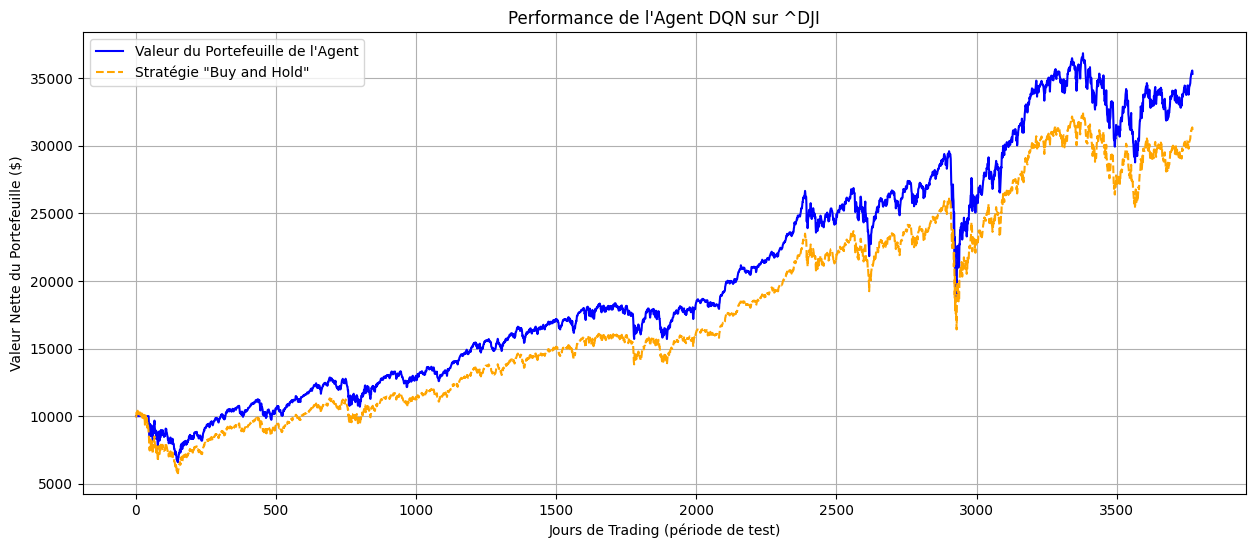

In [14]:
import matplotlib.pyplot as plt

print("\n--- PARTIE 5 : Évaluation de l'agent sur le ^DJI ---")

# Créer un dictionnaire ne contenant que les données de test
test_ticker = '^DJI'
test_data_dict = {test_ticker: data_by_ticker[test_ticker]}

# Instancier l'environnement de test
env_test = MultiStockTradingEnv(data_dict=test_data_dict)

obs, info = env_test.reset()
done = False

# NOUVEAU : Créer une liste pour stocker l'historique de la valeur nette
net_worth_history = [env_test.initial_balance]

print(f"\n--- Début du Backtesting sur {env_test.current_ticker} ---")
while not done:
    action, _states = model_dqn.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated
    
    # NOUVEAU : Ajouter la nouvelle valeur nette à l'historique
    net_worth_history.append(env_test.net_worth)

# --- Calculer les résultats ---
final_net_worth = env_test.net_worth
initial_balance = env_test.initial_balance
roi = ((final_net_worth - initial_balance) / initial_balance) * 100

print("\n--- Fin du Backtesting ---")
print(f"Bilan Initial : {initial_balance:.2f} $")
print(f"Bilan Final   : {final_net_worth:.2f} $")
print(f"Retour sur Investissement (ROI) final : {roi:.2f}%")

# --- NOUVEAU : Création du graphique ---
plt.figure(figsize=(15, 6))
plt.plot(net_worth_history, label='Valeur du Portefeuille de l\'Agent', color='blue')
# Pour comparer, on peut tracer une ligne représentant le "buy and hold"
# (acheter au début et ne plus rien faire)
plt.plot(env_test.data['Close'] / env_test.data['Close'].iloc[0] * initial_balance, label='Stratégie "Buy and Hold"', color='orange', linestyle='--')

plt.title(f'Performance de l\'Agent DQN sur {test_ticker}')
plt.xlabel('Jours de Trading (période de test)')
plt.ylabel('Valeur Nette du Portefeuille ($)')
plt.legend()
plt.grid(True)
plt.show()